### Imports

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import ScalarMappable
import matplotlib
import scipy
import seaborn as sns
import scikit_posthocs as sp
import warnings
warnings.filterwarnings("ignore", category=Warning)

### Set input/output paths and read in data tables
Find sample input files in the main directory

In [2]:
#path to input folder (fill your own path in here)
inputs =  '/global/cfs/cdirs/m342/lblum/hotsprings_metaG/jupyter_notebooks/publication_material/input_files'

#sample/metagenome metadata
sample_meta = pd.read_csv(os.path.join(inputs, 'thermal_springs_genomes_meta_pH_range.csv'))

#Output folder (put your own output folder path here)
outputs = '/global/cfs/cdirs/m342/lblum/hotsprings_metaG/jupyter_notebooks/publication_material/output_files'

#Table with grs abundance data.  Note, at this stage relative abundance per metagenomic sample was reported in reads per million (RPM). 
#This was obtained by summing the average scaffold coverage associated with grs sequences in a particular sample (in reads) and dividing by the total mapped reads (in millions). 
reads_meta = pd.read_csv(os.path.join(inputs, 'grs_Yellowstone_abundance.csv'))

#Table of bins searched in the analysis, including lineage and copy number info 
bin_info = pd.read_csv(os.path.join(inputs, 'bin_searched_info.csv'))

#Metadata for thermal springs isolates 
isolates_rep = pd.read_csv(os.path.join(inputs,'isolates_copynumber_table.csv'))

#metadata for grs gene hits detected in the hmmer search 
hits_info = pd.read_csv(os.path.join(inputs, 'grs_fam_threshold_hits_info_table.csv'))

#info for completely identical amino acid hits
redundant_hits_400 = pd.read_csv(os.path.join(inputs, "grs_redundant_copies.csv"), header = None, sep = '\t')
redundant_hits_400.columns = ['gene oid','duplicates','cluster']

#info for grs sequences associated with bins
bin_genes = pd.read_csv(os.path.join(inputs,'gene_seqs_bin_info.csv'))

#Degree sign
degree_sign = u'\N{DEGREE SIGN}'

### Thermal springs pH and temperature distributions
Look at the pH/temperature distribution of samples for which grs was detected

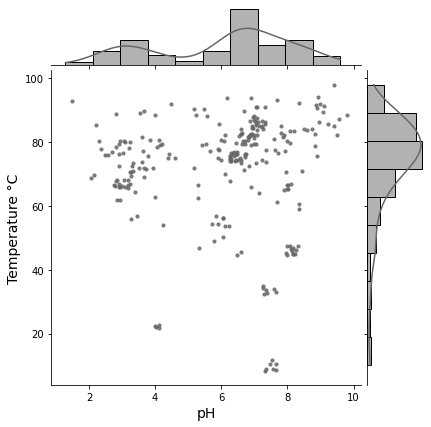

In [3]:
#Find out which samples contained grs hits from the gene hits info table
hits_samples = hits_info['sample_id'].unique().tolist()
detected_samples = sample_meta[sample_meta['taxon_oid'].isin(hits_samples)]

df = detected_samples
g = sns.jointplot(data = df, x = 'pH_avg', y = 'temperature_num',space = 0.1, kind = 'reg', y_jitter = 2, x_jitter= 0.25, color = '#666666', fit_reg = False, marginal_kws = dict(bins=10, fill=True), scatter_kws={'s':10})
#Add jitter to see points that are on top of each other
#Use seaborn to make a scatterplot with histograms and kernel density estimate on each axis.
g.ax_joint.set_xlabel('pH', size = 14)
g.ax_joint.set_ylabel('Temperature '+degree_sign + "C", size = 14)

plt.show(g)
g.savefig(os.path.join(outputs,'pH_temp_detected_samples.png'), dpi= 300)

### $\it{grs}$ relative abundance and environmental conditions

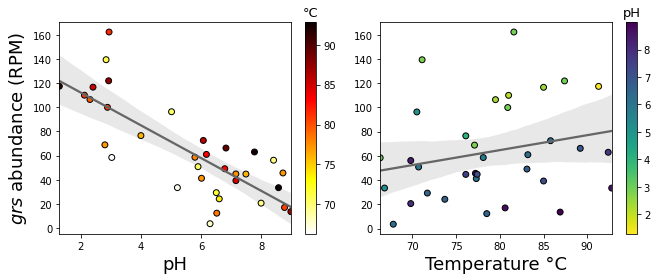

In [3]:
#Use seaborn's regplot, like a scatterplot along with lines for linear regression and shading for a 95% confidence interval.
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(9.5, 4))

data = reads_meta.loc[:,['grs/mapped_reads','pH','temperature_num']]
plt.subplot(1,2,1)

cmap = 'hot_r'
norm= plt.Normalize(data['temperature_num'].min(), data['temperature_num'].max())
sns.regplot(x = data['pH'], y= data['grs/mapped_reads'] , scatter=False, color=".4", ax = ax1, ci = 95)
ax1.scatter(data['pH'], data['grs/mapped_reads'], c = data['temperature_num'], cmap = cmap, norm = norm, s = 35, edgecolor = 'black');
plt.ylabel('$\it{grs}$ abundance (RPM)', fontsize = '18')
plt.xlabel("pH", fontsize = '18')
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm)
cbar.ax.set_title(degree_sign + "C", fontsize = '13')


plt.subplot(1,2,2)
cmap = 'viridis_r'
norm = plt.Normalize(data['pH'].min(), data['pH'].max())        
sns.regplot(x = data['temperature_num'], y= data['grs/mapped_reads'] , scatter=False, color="0.4", ax = ax2, ci = 95)
ax2.scatter(data['temperature_num'], data['grs/mapped_reads'],norm = norm, c = data['pH'], cmap = cmap, s = 35, edgecolor = 'black');
plt.ylabel('', fontsize = '18')
plt.xlabel('Temperature ' + degree_sign + "C", fontsize = '18')
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(sm)
cbar.ax.set_title('pH', fontsize = '13')

plt.tight_layout()
fig.savefig(os.path.join(outputs,'abundance_pH_temp_reg.png'), dpi= 300)

###  $\it{grs}$ Copy Number and taxonomic class

In [5]:
# Only look at bins for which grs was detected
grs_bins = bin_info[bin_info['grs_present'] == 1]
#Get columns for phylum, class, order, family
grs_bins.loc[:,'Phylum'] = grs_bins['lineage'].str.split(';').str[1]
grs_bins.loc[:,'Class'] = grs_bins['lineage'].str.split(';').str[2]
grs_bins.loc[:,'Order'] = grs_bins['lineage'].str.split(';').str[3]
grs_bins.loc[:,'Family'] = grs_bins['lineage'].str.split(';').str[4]

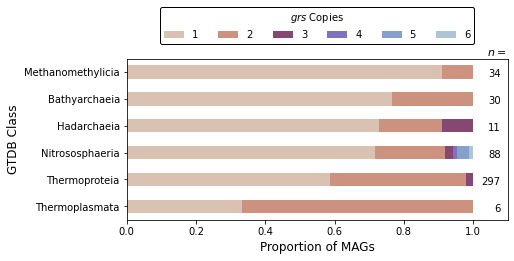

In [58]:
#Compute copy number counts for each taxonomic class
df = grs_bins.loc[:,['copy_number','Phylum','Class']].dropna()

df1 = df[df['copy_number']==1].groupby('Class').count().loc[:,'copy_number']
df2 = df[df['copy_number']==2].groupby('Class').count().loc[:,'copy_number']
df3 = df[df['copy_number']==3].groupby('Class').count().loc[:,'copy_number']
df4 = df[df['copy_number']==4].groupby('Class').count().loc[:,'copy_number']
df5 = df[df['copy_number']==5].groupby('Class').count().loc[:,'copy_number']
df6 = df[df['copy_number']==6].groupby('Class').count().loc[:,'copy_number']

cat_df = pd.concat([df1, df2, df3, df4, df5, df6] , axis = 1)
cat_df.columns = ['1','2','3','4','5','6']
cat_df_p = cat_df.div(cat_df.sum(axis=1), axis=0)
cat_df_p['total'] = cat_df.sum(axis=1)
cat_df_p = cat_df_p.sort_values('1') #Sort values to order the data table
cat_df_p.index = cat_df_p.index.str.replace('c__', '')
#limited to more than 1 copy. 
my_cmap = plt.get_cmap("twilight_r")
cat_df_p=cat_df_p[cat_df_p['1']<1]

fig, ax = plt.subplots(figsize=(7.25,4))
cat_df_p.iloc[:,:-1].plot(    
    kind = 'barh',
    stacked = True,
    mark_right = True, ax = ax, color = my_cmap([50, 100, 200, 350, 400, 450]), alpha = 0.8)

totals = cat_df_p['total']
count = 0
for total in totals:
    ax.text(1.08, -0.2+count*1,str(int(total)), ha='right')
    count = count+1
ax.text(1.04, 5.6, "$\it{n=}$", fontsize = '11')

ax.set_xlim(0,1.1)

ax.legend(bbox_to_anchor=(0, 0., 1, 1.35),
              loc='upper center', fontsize='medium', title = '$\it{grs}$ Copies', ncol = 6, framealpha = 1, edgecolor = 'black')

ax.set_xlabel('Proportion of MAGs', size = 'large')
ax.set_ylabel('GTDB Class', size = 'large')

plt.tight_layout()
fig.savefig(os.path.join(outputs,'class_copy_number_lim.png'), dpi= 300)

### Copy number and pH/temperature in isolates
Use seaborn violin plot and stripplot as alternatives to boxplot to show distribution of pH/temperature and copy number of isolates.



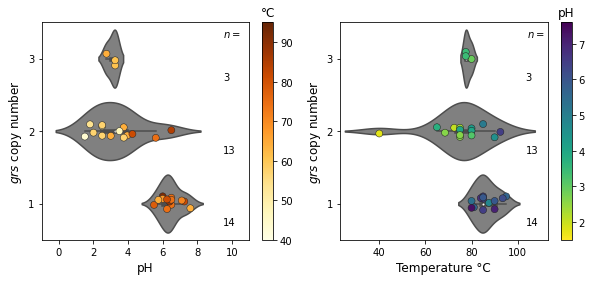

In [6]:
df = isolates_rep.loc[:,['contig_id', 'pH_avg' ,'temperature_num']].dropna() #contig_id column represents number of grs copies
df = df[df['contig_id']>0] #Looking at copy numbers >0.
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 4))

#plot violinplot with stripplot overlay, colored by temperature.
plt.subplot(1,2,1)
cmap = plt.get_cmap('YlOrBr')
sns.violinplot(y = df.contig_id, x = df.pH_avg, color = 'gray', order = [3,2,1], scale = 'width', orient = 'h')
st = sns.stripplot(y = df.contig_id, x = df.pH_avg, size=7, 
                     hue = df['temperature_num'], palette = 'YlOrBr', order = [3,2,1], edgecolor="gray", ax=ax1, linewidth=.5, orient = 'h')

norm = plt.Normalize(df['temperature_num'].min(), df['temperature_num'].max())
sm = ScalarMappable(norm=norm, cmap=cmap) 
sm.set_array([])       
cbar = fig.colorbar(sm, ax = ax1)
cbar.ax.set_title(degree_sign + "C", fontsize = '12')
ax1.get_legend().remove()
ax1.set_xlabel('pH',fontsize = '12')
ax1.set_ylabel('$\it{grs}$ copy number', fontsize = '12')
ax1.set_xlim(-1,11)
ax1.set_xticks(np.arange(0, 10.5, 2))

#add n values above each violinplot
stringlist = df.groupby('contig_id').count()['pH_avg'].sort_values(ascending = True).to_list()
for i in range(len(stringlist)):
    ax1.text(9.5, i+0.3, stringlist[i], fontsize = '10')
ax1.text(9.5, -0.3, "$\it{n=}$")

#Now distribution of temperatures, colored by pH
plt.subplot(1,2,2)
cmap = plt.get_cmap('viridis_r')
sns.violinplot(y = df.contig_id, x = df.temperature_num, color = 'gray', order = [3,2,1], scale = 'width', orient = 'h')
st = sns.stripplot(y = df.contig_id,x = df.temperature_num, size=7, orient="h", 
                    hue = df['pH_avg'], order = [3,2,1], palette = 'viridis_r', edgecolor="gray", ax=ax2, linewidth=.5)

norm = plt.Normalize(df['pH_avg'].min(), df['pH_avg'].max())
sm = ScalarMappable(norm=norm, cmap=cmap) 
sm.set_array([])
cbar = fig.colorbar(sm, ax = ax2)
cbar.ax.set_title('pH', fontsize = '12')
ax2.get_legend().remove()
ax2.set_xlabel('Temperature '+degree_sign + "C",fontsize = '12')
ax2.set_ylabel('$\it{grs}$ copy number', fontsize = '12')
ax2.set_xlim(23,113)
ax2.set_xticks(np.arange(40, 110, 20))

#add n values
for i in range(len(stringlist)):
    ax2.text(103.4, i+0.3, stringlist[i], fontsize = '10')
ax2.text(104, -0.3, "$\it{n=}$")

plt.subplots_adjust(wspace=.15)
plt.show()

fig.savefig(os.path.join(outputs,'isolates_copynumber_hozviolin.png'), dpi= 300)

### Copy number and pH/temperature in metagenome bins
Use seaborn violin plot and stripplot as alternatives to boxplot to show distribution of pH/temperature and copy number of bins.



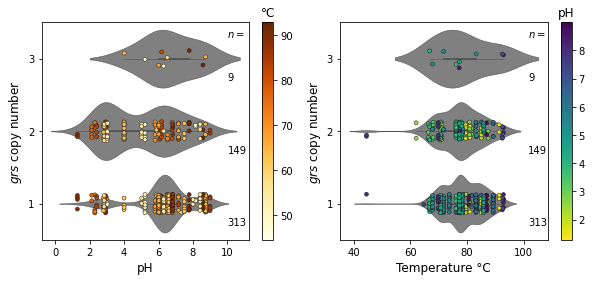

In [7]:
#Only use bins with pH AND temperature data for consistency.
df = grs_bins.loc[:,['copy_number', 'pH_avg', 'temperature_num']].dropna()
df = df[df['copy_number']<4]
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 4))

cmap = plt.get_cmap('YlOrBr')
norm = plt.Normalize(df['temperature_num'].min(), df['temperature_num'].max())
sm = ScalarMappable(norm=norm, cmap=cmap) 
sm.set_array([])       

plt.subplot(1,2,1)

#plot violinplot with stripplot overlay, colored by temperature.
sns.violinplot(y = df['copy_number'], x = df['pH_avg']
              , color = 'gray', order = [3,2,1], edgecolor="gray", ax=ax1, linewidth=.5 
             ,alpha = 0.7, size = 3, scale = 'width', orient = 'h')
sns.stripplot(y = df['copy_number'], x = df['pH_avg']
             ,hue = df['temperature_num'], order = [3,2,1], palette = 'YlOrBr', edgecolor="gray", ax=ax1, linewidth=.5 
             ,alpha = 1, size = 4, jitter = 0.13, orient = 'h')

cbar = fig.colorbar(sm, ax = ax1)
cbar.ax.set_title(degree_sign + "C", fontsize = '12')
ax1.set_xlabel('pH',fontsize = '12')
ax1.set_ylabel('$\it{grs}$ copy number', fontsize = '12')
ax1.get_legend().remove()
ax1.set_xticks(np.arange(0, 10.5, 2))

cmap = plt.get_cmap('viridis_r')
norm = plt.Normalize(df['pH_avg'].min(), df['pH_avg'].max())
sm = ScalarMappable(norm=norm, cmap=cmap) 
sm.set_array([])    

#add n values above each violinplot
stringlist = df.groupby('copy_number').count()['pH_avg'].sort_values(ascending = True).to_list()
for i in range(len(stringlist)):
    ax1.text(10, i+0.3, stringlist[i], fontsize = '10')
ax1.text(10, -0.3, "$\it{n=}$")

plt.subplot(1,2,2)
#plot violinplot with stripplot overlay, colored by pH.
sns.violinplot(y = df['copy_number'], x = df['temperature_num'] 
              , color = 'gray', order = [3,2,1], edgecolor="gray", ax=ax2, linewidth=.5 
             , alpha = 0.7, size = 4, scale = 'width', orient = 'h')
sns.stripplot(y = df['copy_number'], x = df['temperature_num'],
              hue = df['pH_avg'], order = [3,2,1], palette = 'viridis_r', edgecolor="gray", ax=ax2, linewidth=.5 
             , alpha = 1, size = 4
              , jitter = 0.13, orient = 'h')
cbar = fig.colorbar(sm, ax = ax2)
cbar.ax.set_title('pH', fontsize = '12')
ax2.set_xlabel('Temperature '+degree_sign + "C",fontsize = '12')
ax2.set_ylabel('$\it{grs}$ copy number', fontsize = '12')
ax2.get_legend().remove()
ax2.set_xticks(np.arange(40, 110, 20))

#add n values above each violinplot
for i in range(len(stringlist)):
    ax2.text(101.5, i+0.3, stringlist[i], fontsize = '10')
ax2.text(101.5, -0.3, "$\it{n=}$")

plt.subplots_adjust(wspace=.15)

fig.savefig(os.path.join(outputs,'bins_copynumber_hozviolin.png'), dpi= 300)

### Redundancy bubble plot
Observe the distribution of redundant (completely identical) amino acid sequences for grs genes.
- Associate these sequences, where possible with taxonomic lineage of bins

In [4]:
#First, prepare the list of redundant sequences by merging it with metadata
redundant_hits_400_info = pd.merge(redundant_hits_400, hits_info, left_on = 'gene oid', right_on = 'contig_id').drop('Unnamed: 0', axis = 1)
bin_genes = bin_genes.reset_index()
bin_genes2 = pd.merge(bin_genes.loc[:,['bin_name', 'gene_oid']], bin_info, left_on = 'bin_name', right_on = 'bin_name')
bin_genes2['gene_oid'] = bin_genes2['gene_oid'].str.split(' ').str[2]
in_bins = redundant_hits_400_info[redundant_hits_400_info['contig_id'].isin(bin_genes['gene_oid'].str.split(' ').str[2].tolist())]
redundant_hits_400_info = redundant_hits_400_info.set_index('gene oid')
bin_genes2 = bin_genes2.set_index('gene_oid')

classl = []
for item in bin_genes2['lineage']:
    cl = item.split(';')[2]
    classl.append(cl)
    
bin_genes2['class'] = classl   
#check for different class identifications --> no sequences found associated with bins of different classes
lindict = {}
for item in redundant_hits_400_info.index:
    c_set = set()
    if item in in_bins['gene oid'].tolist():
        cl = bin_genes2.loc[item]['class']
        c_set.add(cl)
    else:        
        for i in redundant_hits_400_info.loc[item]['cluster'].split(','):
            if i in bin_genes2.index.tolist():
                cl = bin_genes2.loc[i]['class']
                c_set.add(cl)
            else:
                pass
        
    lindict[item] = c_set

In [5]:
#Create a dictionary matching colors to classes
classes = ['c__Archaeoglobi', 'c__Thermoplasmata', 'c__Methanomethylicia', 'c__Korarchaeia', 'c__Acidobacteriae', 'c__Bathyarchaeia', 'c__Thermoproteia', 'c__Nitrososphaeria']
colors = ['#D1C9F4','#78C3CE','#EE7D53','#F3B07A','#FFFD93','#F8DBDA','#FBD19D','#ECABAA']
c_dict = dict(zip(classes, colors))

#Associate sequences, when possible, with class/color
myset = set()
color_col = []
for i in redundant_hits_400_info.index:
    if i in lindict:        
        cl = lindict.get(i)
        if cl != myset:
            for i in cl:
                ncl = i
                cll = c_dict.get(ncl)
                color_col.append(cll)  
        else:
            cll = '#666666'
            color_col.append(cll)
    else:
        cll = '#666666'
        color_col.append(cll)
    
redundant_hits_400_info['class_color'] = color_col

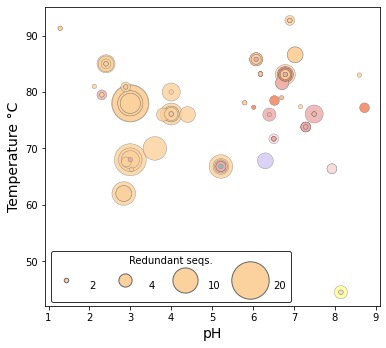

In [9]:
#Produce the figure of redundant sequences associated with bins: each bubble represents a cluster of identical sequences, the size is scaled to the number of sequences
#Colored by taxonomic class of associated bins
fig = plt.figure(figsize =(6,5.5))
ax = fig.add_subplot()
df = redundant_hits_400_info.loc[:,['pH_avg','temperature_num','class_color','duplicates']].dropna()  
df = df[df['class_color']!='#666666']
df = df.sort_values("duplicates", ascending = False)
g = sns.scatterplot(data=df, x="pH_avg", y="temperature_num", size="duplicates", legend= 'full', sizes=(20, 1400), alpha = 0.8, c = df["class_color"], edgecolor = '#666666') 

plt.xlabel('pH', fontsize = '14')
plt.ylabel('Temperature '+degree_sign + "C", fontsize = '14')

handles, labels = g.get_legend_handles_labels()
handles = [handles[0],handles[2], handles[8],handles[11]]
labels = ['2','4','10', '20']
for h in handles:
    sizes = [s for s in h.get_sizes()]
    h.set_sizes(sizes)
    h.set_alpha(1)
    h.set_facecolor('#FBD19D')
    h.set_edgecolor('#666666')

l = g.legend(handles, labels, bbox_to_anchor=(0.75, 0.2), handletextpad = 1.3,borderpad = 0.5,ncol = 4, loc=1, title = 'Redundant seqs.', labelspacing = 0.8, handleheight=3.2, edgecolor = 'black')
plt.show()
#Five groups of redundant sequences at least 10; All of which had pH <4. 
fig.savefig(os.path.join(outputs,'redundancy_bubble_color.png'), dpi= 300)